In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [2]:
path = "datos/"
load_path = path + "{}.hdf"

electrodos = [8, 44, 80, 131, 185]

N_P = 10
N_S = 10
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)


Calcular N para hacer la transformación simbólica. Se va a calcular un N y una medida de información para cada electrodo.
Anteriormente se trató de hacer un alfabeto para todos los electrodos por igual, pero por la diferencia en los valores máximos y mínimos la mayoría de las muestras caían en los mismos símbolos, ejemplo:

<img src="bins.png">

Parte 1
Se toma un alfabeto por cada electrodo con valores promediados y se modela como fuente de información cada tupla (paciente, electrodo)

In [74]:
# Calculo de N (cantidad de bins): Se usa n = 201 porque los epochs tienen esa cantidad de muestras
def calculo_N(df_):
    return math.ceil((df_.max() - df_.min()) / (3.5*df_.std() * 201 ** (-1/3)))

pacientes = pd.concat(pacientes_P + pacientes_S)
val = pacientes.groupby(["sensor","epoch"])['valores'].mean()
i_s = pd.DataFrame({'sensor':electrodos})
i_s['N'] = val.groupby(["sensor"]).apply(calculo_N).values
i_s['min'] = val.groupby(["sensor"]).min().values
i_s['max'] = val.groupby(["sensor"]).max().values
i_s['step'] = (i_s['max'] - i_s['min']) / i_s['N']
i_s = i_s.set_index('sensor')
i_s

,N,min,max,step
sensor,,,,
8,16,-0.000015,0.000015,0.000002
44,18,-0.000020,0.000017,0.000002
80,17,-0.000019,0.000016,0.000002
131,15,-0.000016,0.000013,0.000002
185,16,-0.000015,0.000012,0.000002


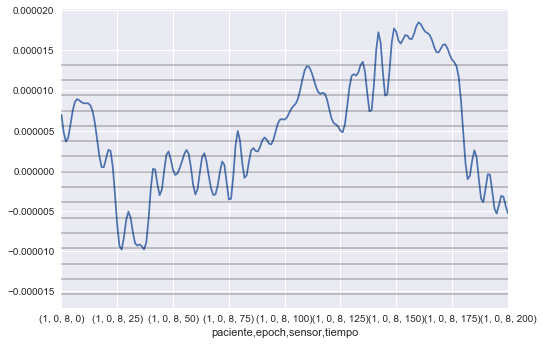

In [75]:
pacientes.loc[1,0,8,:]['valores'].plot()
for i in range(int(i_s.loc[8]['N'])):
    sns.plt.plot((0,200),(i_s.loc[8]['min'] + i*i_s.loc[8]['step'],i_s.loc[8]['min'] + i*i_s.loc[8]['step']),
                 'k-', lw = 0.4)
sns.plt.show()

In [99]:
def obtener_simbolo(v):
    sensor = v.reset_index().sensor[0]
    simbolo = (v - i_s.loc[sensor]['min']) // i_s.loc[sensor]['step']
    return simbolo
pacientes['simbolo'] = pacientes.groupby("sensor").apply(obtener_simbolo).values

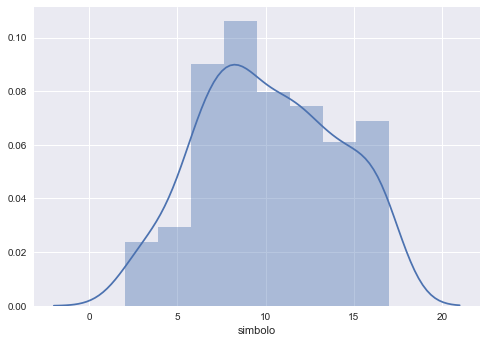

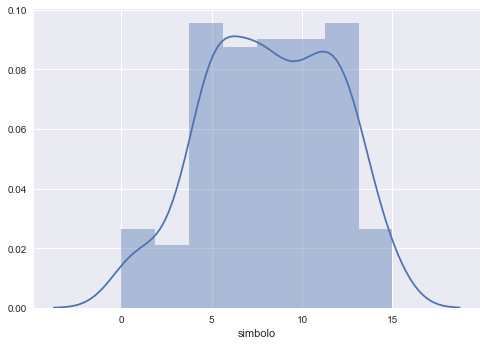

In [102]:
sns.distplot(pacientes.loc[1,0,8,:]['simbolo'])
sns.plt.show()
sns.distplot(pacientes.loc[3,0,8,:]['simbolo'])
sns.plt.show()

In [103]:
pacientes.head()

valores  simbolo
paciente epoch sensor tiempo                       
0        0     8      0      -2.156435e-06      6.0
                      1      -5.516751e-07      7.0
                      2       2.121832e-06      9.0
                      3       4.735732e-06     10.0
                      4       5.841685e-06     11.0

In [104]:
# Calculo de probabilidad de cada símbolo. Cada paciente y sensor se considera una fuente de información distinta
pacientes['repeticiones'] = pacientes.groupby(["paciente", "sensor","simbolo"]).transform('count')['valores']
pacientes['total'] = pacientes.groupby(["paciente", "sensor"]).transform('count')['valores']
pacientes['probabilidad'] = pacientes['repeticiones'] / pacientes['total']
pacientes.head()

valores  simbolo  repeticiones     total  \
paciente epoch sensor tiempo                                                  
0        0     8      0      -2.156435e-06      6.0       20363.0  179694.0   
                      1      -5.516751e-07      7.0       24723.0  179694.0   
                      2       2.121832e-06      9.0       19780.0  179694.0   
                      3       4.735732e-06     10.0       13391.0  179694.0   
                      4       5.841685e-06     11.0        9081.0  179694.0   

                              probabilidad  
paciente epoch sensor tiempo                
0        0     8      0           0.113320  
                      1           0.137584  
                      2           0.110076  
                      3           0.074521  
                      4           0.050536

In [107]:
def calcular_entropia(df_):
    df_ = df_.groupby("simbolo").first()
    p = df_["probabilidad"]
    return -sum(p * np.log(p))

entropias_a = pacientes.groupby(["paciente","sensor"]).apply(calcular_entropia).reset_index()
entropias_a = entropias_a.rename(columns = {0:'Entropia', 'sensor': 'Sensor'})
entropias_a['Capacidad Cognitiva'] = (entropias_a.paciente < 10).apply(lambda x: 'Normal' if x else 'Reducida')

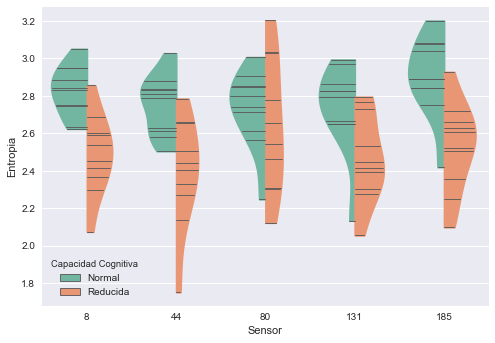

In [108]:
sns.violinplot(x="Sensor", y="Entropia", hue="Capacidad Cognitiva", data=entropias_a, 
               split=True, palette="Set2", inner="stick", cut=0)
sns.plt.show()

In [109]:
# Evaluo la media de información por sensor comparando los individuos con capacidad cognitiva reducida y normal
# Uso rank sum con hipótesis nula: "Ambas muestras tienen la misma media"

for s in electrodos:
    x = entropias_a[(entropias_a.Sensor == s) & (entropias_a['Capacidad Cognitiva'] == 'Reducida')].Entropia
    y = entropias_a[(entropias_a.Sensor == s) & (entropias_a['Capacidad Cognitiva'] != 'Reducida')].Entropia
    _, p = scipy.stats.ranksums(x,y)
    print('p-valor misma media para sensor {}: {}'.format(s,p))

# Tomando un alfabeto común por electrodo y modelando como fuente de información cada tupla (paciente, electrodo) 
# Parece ser posible utilizar los sensores 8, 44, 131 y 185 para identificar las ca
# Se 

p-valor misma media para sensor 8: 0.001498873337151676
p-valor misma media para sensor 44: 0.005158957570721309
p-valor misma media para sensor 80: 0.5453496680111236
p-valor misma media para sensor 131: 0.015564411386633814
p-valor misma media para sensor 185: 0.004071994217732759


Parte 2

Todos los electrodos comparten los mismos símbolos.
Las fuentes de información son cada uno de los electrodos promediados


In [16]:
df_P = pd.concat(pacientes_P)
df_SP = df_P.groupby(["sensor","tiempo"]).mean()
df_S = pd.concat(pacientes_S)
df_SS = df_S.groupby(["sensor", "tiempo"]).mean()

In [18]:
df_SS.head()

valores
sensor tiempo              
8      0      -8.804419e-09
       1      -2.458968e-08
       2      -2.306229e-08
       3      -1.044884e-08
       4       3.611096e-09

In [19]:
# Calcular N para hacer la transformación simbólica
pacientes_b_mean = pd.concat(pacientes_P + pacientes_S).groupby(["sensor","tiempo"]).mean()
N_b = math.ceil(pacientes_b_mean.max() - pacientes_b_mean.min() / (pacientes_b_mean.std() * len(pacientes_b_mean) ** (-1/3)))
step_b = (pacientes_b_mean.max() - pacientes_b_mean.min()) / N_b

print(N_b, step_b)

29 valores    6.655843e-08
dtype: float64


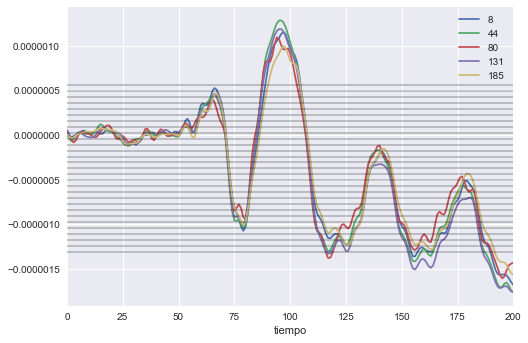

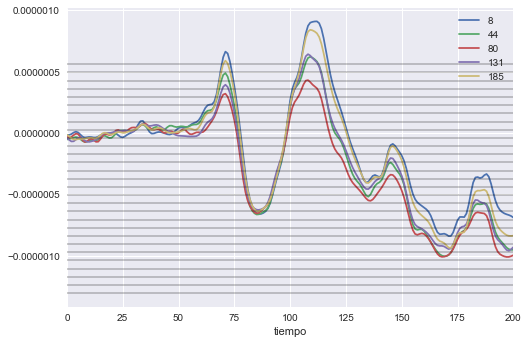

In [21]:
# Las lineas indican la separacion en símbolos
start_b = pacientes_b_mean.min()

fig, ax = sns.plt.subplots(1,1) 
df_SS.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SS.groupby('sensor')])
for i in range(N_b):
    sns.plt.plot((0,200),(start_b + i*step_b,start_b + i*step_b), 'k-', lw = 0.4)

sns.plt.show()

fig, ax = sns.plt.subplots(1,1) 
df_SP.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SP.groupby('sensor')])
for i in range(N_b):
    sns.plt.plot((0,200),(start_b + i*step_b,start_b + i*step_b), 'k-', lw = 0.4)

sns.plt.show()

In [23]:
# Asigno simbolos de acuerdo al valor
def obtener_simbolo_b(v):
    return (v - pacientes_b_mean.min()) // step_b
df_SS['simbolo'] = df_SS['valores'].apply(obtener_simbolo_b)
df_SP['simbolo'] = df_SP['valores'].apply(obtener_simbolo_b)

df_SP.head()

valores  simbolo
sensor tiempo                       
8      0      -1.612741e-08     19.0
       1      -1.618464e-08     19.0
       2      -9.173112e-09     19.0
       3       3.026673e-09     19.0
       4       1.021965e-08     19.0

In [24]:
df_SP['repeticiones'] = df_SP.groupby(["sensor","simbolo"]).transform('count')['valores']
df_SP['total'] = df_SP.groupby(["sensor"]).transform('count')['valores']
df_SP['probabilidad'] = df_SP['repeticiones'] / df_SP['total']
df_SS['repeticiones'] = df_SS.groupby(["sensor","simbolo"]).transform('count')['valores']
df_SS['total'] = df_SS.groupby(["sensor"]).transform('count')['valores']
df_SS['probabilidad'] = df_SS['repeticiones'] / df_SS['total']

df_SS.head()

valores  simbolo  repeticiones  total  probabilidad
sensor tiempo                                                          
8      0      -8.804419e-09     19.0          28.0  201.0      0.139303
       1      -2.458968e-08     19.0          28.0  201.0      0.139303
       2      -2.306229e-08     19.0          28.0  201.0      0.139303
       3      -1.044884e-08     19.0          28.0  201.0      0.139303
       4       3.611096e-09     19.0          28.0  201.0      0.139303

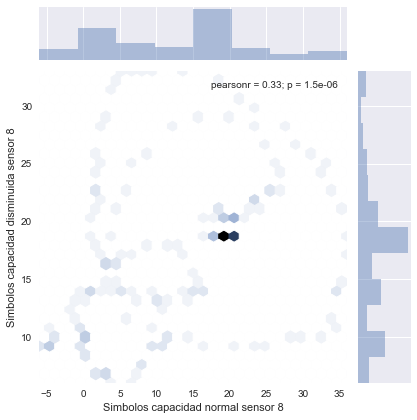

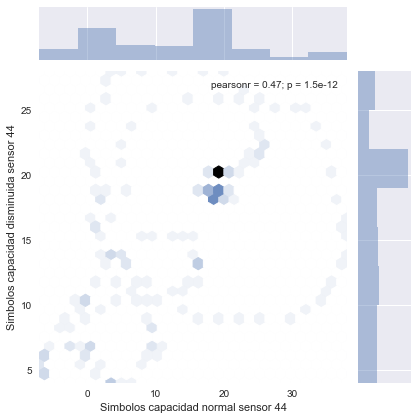

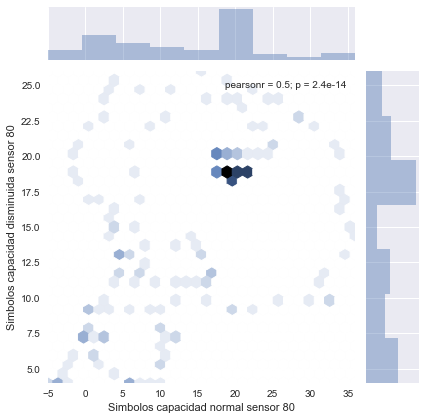

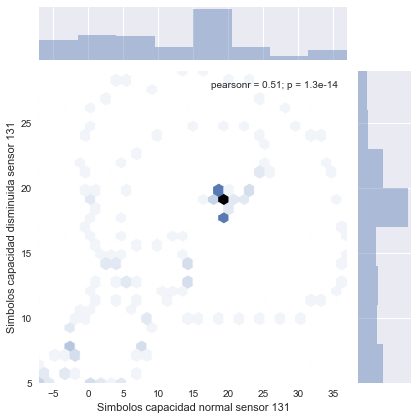

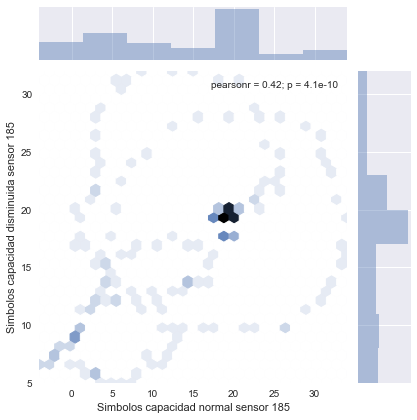

In [25]:
# Comparación de sensores entre personas con capacidad disminuida y normal
for e in electrodos:
    sensorX = df_SS.loc[e]['simbolo']
    sensorY = df_SP.loc[e]['simbolo']
    sns.jointplot(sensorX, sensorY, kind='hex', gridsize=30).set_axis_labels(
        "Simbolos capacidad normal sensor {}".format(e), "Simbolos capacidad disminuida sensor {}".format(e))

sns.plt.show()



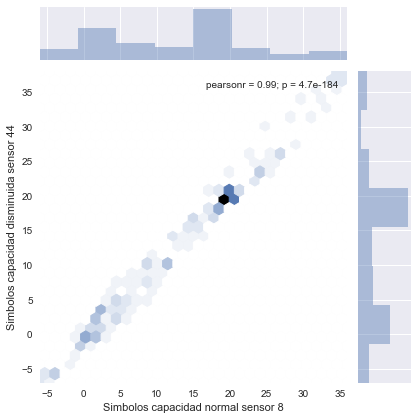

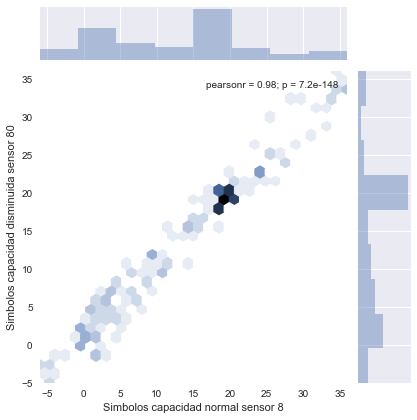

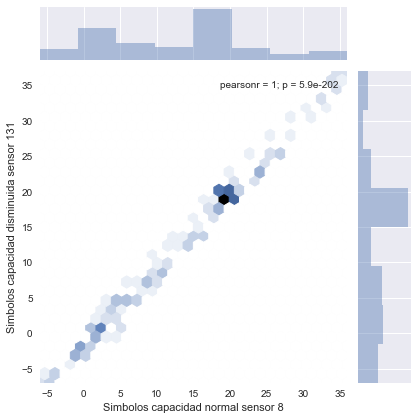

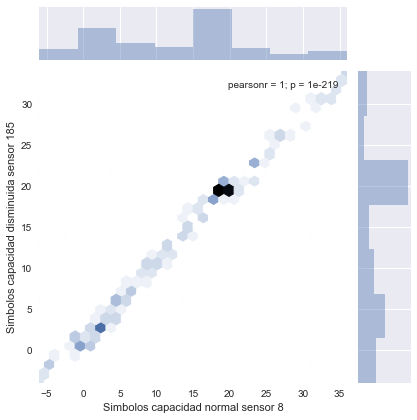

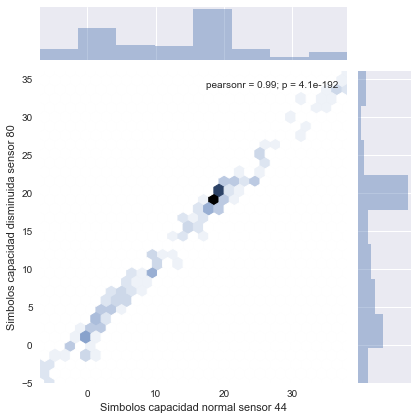

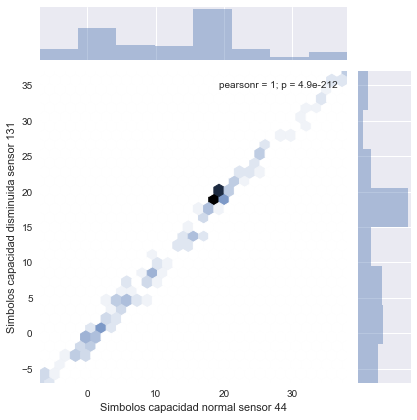

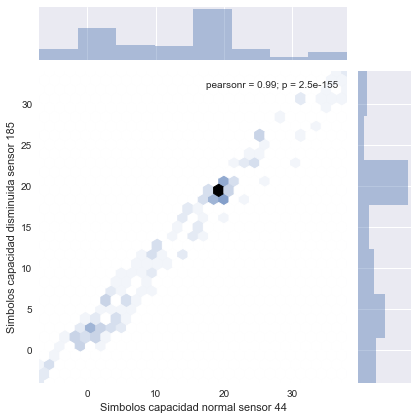

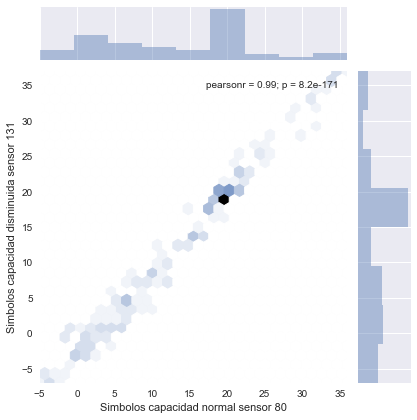

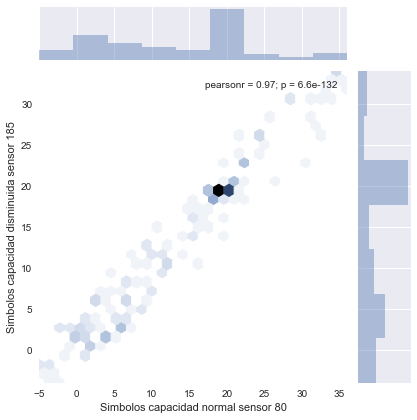

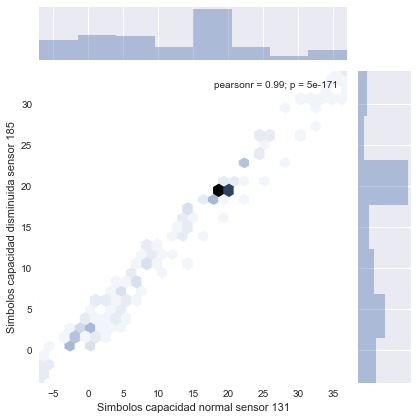

In [27]:
# Comparación de sensores distintos de personas con capacidad cognitiva normal
for i, e1 in enumerate(electrodos):
    for e2 in electrodos[i+1:]:
        sensorX = df_SS.loc[e1]['simbolo']
        sensorY = df_SS.loc[e2]['simbolo']
        sns.jointplot(sensorX, sensorY, kind='hex', gridsize=30).set_axis_labels(
            "Simbolos capacidad disminuida sensor {}".format(e1), "Simbolos capacidad disminuida sensor {}".format(e2))

sns.plt.show()



Se ve claramente las diferencias entre los valores de simbolos de electrodos de personas con capacidades reducidas y normales